In [1]:
# -*- coding: UTF-8 -*-

"""
NormalWishart-Normal Model
Posterior inference with Edward BBVI
[DOING]
"""

import edward as ed
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from edward.models import MultivariateNormalTriL, WishartCholesky
from scipy.stats import invwishart

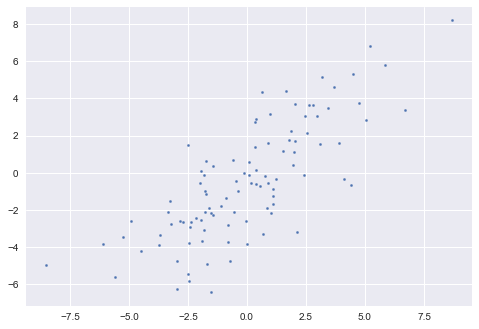

mu=[ 0.29130432 -0.39232118]
sigma=[[ 7.41915012  5.5040112 ]
 [ 5.5040112   8.024716  ]]


In [2]:
N = 100
D = 2

# Data generation
# NIW Inverse Wishart hyperparameters
v = 3.
W = np.array([[20., 30.], [25., 40.]], dtype=np.float32)
sigma = invwishart.rvs(v, W)
# NIW Normal hyperparameters
m = np.array([1., 1.], dtype=np.float32)
k = 0.8
mu = np.random.multivariate_normal(m, sigma / k)
xn_data = np.random.multivariate_normal(mu, sigma, N).astype(np.float32)
plt.scatter(xn_data[:, 0], xn_data[:, 1], cmap=cm.gist_rainbow, s=5)
plt.show()
print('mu={}'.format(mu))
print('sigma={}'.format(sigma))

In [3]:
# Prior definition
v_prior = tf.Variable(3., dtype=tf.float32, trainable=False)
W_prior = tf.Variable(np.array([[1., 0.], [0., 1.]]),
                      dtype=tf.float32, trainable=False)
m_prior = tf.Variable(np.array([0.5, 0.5]), dtype=tf.float32, trainable=False)
k_prior = tf.Variable(0.6, dtype=tf.float32, trainable=False)

print('***** PRIORS *****')
print('v_prior: {}'.format(v_prior))
print('W_prior: {}'.format(W_prior))
print('m_prior: {}'.format(m_prior))
print('k_prior: {}'.format(k_prior))

***** PRIORS *****
v_prior: <tf.Variable 'Variable:0' shape=() dtype=float32_ref>
W_prior: <tf.Variable 'Variable_1:0' shape=(2, 2) dtype=float32_ref>
m_prior: <tf.Variable 'Variable_2:0' shape=(2,) dtype=float32_ref>
k_prior: <tf.Variable 'Variable_3:0' shape=() dtype=float32_ref>


In [4]:
# Posterior inference
# Probabilistic model
sigma = WishartCholesky(df=v_prior, scale=W_prior)
mu = MultivariateNormalTriL(loc=m_prior, scale_tril=k_prior * sigma)
#xn = MultivariateNormalTriL(loc=tf.reshape(tf.tile(mu, [N]), [N, D]),
#                            scale_tril=tf.reshape(tf.tile(sigma, [N, 1]), [N, 2, 2]))
xn = MultivariateNormalTriL(loc=tf.tile(tf.reshape(mu, [1,D]), [N, 1]),
                            scale_tril=tf.tile(tf.reshape(sigma, [1, D, D]), [N, 1, 1]))

print('***** PROBABILISTIC MODEL *****')
print('mu: {}'.format(mu))
print('sigma: {}'.format(sigma))
print('xn: {}'.format(xn))

***** PROBABILISTIC MODEL *****
mu: RandomVariable("MultivariateNormalTriL_3/", shape=(2,), dtype=float32)
sigma: RandomVariable("WishartCholesky_2/", shape=(2, 2), dtype=float32)
xn: RandomVariable("MultivariateNormalTriL_7/", shape=(100, 2), dtype=float32)


In [ ]:
# Variational model
qmu = MultivariateNormalTriL(
    loc=tf.Variable(tf.random_normal([D], dtype=tf.float32), name='v1'),
    scale_tril=tf.nn.softplus(
        tf.Variable(tf.random_normal([D, D], dtype=tf.float32), name='v2')))

qsigma = WishartCholesky(
    df=tf.nn.softplus(
        tf.Variable(tf.random_normal([], dtype=tf.float32), name='v3')),
    scale=tf.nn.softplus(
        tf.Variable(tf.random_normal([D, D], dtype=tf.float32), name='v4')))

print('***** VARIATIONAL MODEL *****')
print('qmu: {}'.format(qmu))
print('qsigma: {}'.format(qsigma))
print('xn_data: {}'.format(xn_data.dtype))

***** VARIATIONAL MODEL *****
qmu: RandomVariable("MultivariateNormalTriL_11/", shape=(2,), dtype=float32)
qsigma: RandomVariable("WishartCholesky_5/", shape=(2, 2), dtype=float32)
xn_data: float32


In [ ]:
# Inference
import datetime, os
logdir_base = 'C:\\Users\skruz\\temp\\tensorflow\\'
inference = ed.KLqp({mu: qmu, sigma: qsigma}, data={xn: xn_data})
log_run = datetime.datetime.strftime(datetime.datetime.utcnow(), "%Y-%m-%dT%H%M%SZ")
inference.run(n_iter=2000, n_samples=20, logdir=os.path.join(logdir_base, log_run))

In [ ]:
L = tf.Variable(tf.random_normal([D, D], dtype=tf.float32))
qsigma = WishartCholesky(
    tf.nn.softplus(
        tf.Variable(tf.random_normal([], dtype=tf.float32))+D+1),
    LinearOperatorTriL(L).to_dense())